# NLP From Scratch: Generating Names with a Character-Level RNN

### Preparing the Data

In [1]:
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
from typing import List, Dict, Tuple
import torch
import torch.nn as nn

all_letters: str = string.ascii_letters + " .,;'-"
n_letters: int = len(all_letters) + 1  # Plus EOS marker


def findFiles(path: str) -> List[str]:
    """Find all files matching the given path pattern."""
    return glob.glob(path)

def unicodeToAscii(s: str) -> str:
    """
    Turn a Unicode string to plain ASCII.
    Thanks to https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


def readLines(filename: str) -> List[str]:
    """Read a file and split into lines."""
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines: Dict[str, List[str]] = {}
all_categories: List[str] = []

for filename in findFiles('data/names/*.txt'):
    category: str = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines: List[str] = readLines(filename)
    category_lines[category] = lines

n_categories: int = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['French', 'Korean', 'Greek', 'Dutch', 'Arabic', 'Portuguese', 'English', 'Czech', 'Chinese', 'Irish', 'Vietnamese', 'Japanese', 'Italian', 'Spanish', 'Russian', 'Polish', 'German', 'Scottish']
O'Neal


### Creating the Network

#### ![](./RNN.png)

In [2]:
class RNN(nn.Module):
    """RNN for generating names conditioned on category."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(RNN, self).__init__()
        self.hidden_size: int = hidden_size
        
        self.i2h: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o: nn.Linear = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o: nn.Linear = nn.Linear(hidden_size + output_size, output_size)
        self.dropout: nn.Dropout = nn.Dropout(0.1)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(
        self, 
        category: torch.Tensor, 
        input: torch.Tensor, 
        hidden: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        input_combined: torch.Tensor = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output: torch.Tensor = self.i2o(input_combined)
        output_combined: torch.Tensor = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self) -> torch.Tensor:
        """Initialize hidden state with zeros."""
        return torch.zeros(1, self.hidden_size)


## Training

### Preparing for Training

#### ![](./tokens.png)

In [3]:
def randomChoice(l: List[str]) -> str:
    """Random item from a list."""
    return l[random.randint(0, len(l) - 1)]


def randomTrainingPair() -> Tuple[str, str]:
    """Get a random category and random line from that category."""
    category: str = randomChoice(all_categories)
    line: str = randomChoice(category_lines[category])
    return category, line

In [5]:
def categoryTensor(category: str) -> torch.Tensor:
    """One-hot vector for category."""
    li: int = all_categories.index(category)
    tensor: torch.Tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


def inputTensor(line: str) -> torch.Tensor:
    """One-hot matrix of first to last letters (not including EOS) for input."""
    tensor: torch.Tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter: str = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


def targetTensor(line: str) -> torch.LongTensor:
    """LongTensor of second letter to end (EOS) for target."""
    letter_indexes: List[int] = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

In [6]:
def randomTrainingExample() -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Make category, input, and target tensors from a random category, line pair."""
    category: str
    line: str
    category, line = randomTrainingPair()
    category_tensor: torch.Tensor = categoryTensor(category)
    input_line_tensor: torch.Tensor = inputTensor(line)
    target_line_tensor: torch.Tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Training the Network

In [7]:
criterion: nn.NLLLoss = nn.NLLLoss()
learning_rate: float = 0.0005


def train(
    category_tensor: torch.Tensor, 
    input_line_tensor: torch.Tensor, 
    target_line_tensor: torch.Tensor
) -> Tuple[torch.Tensor, float]:
    """Train the RNN on one example."""
    target_line_tensor.unsqueeze_(-1)
    hidden: torch.Tensor = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss: torch.Tensor = torch.Tensor([0])  # you can also just simply use loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output: torch.Tensor
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l: torch.Tensor = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

In [8]:
def timeSince(since: float) -> str:
    """Calculate time elapsed since given timestamp."""
    now: float = time.time()
    s: float = now - since
    m: int = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
# Initialize RNN
rnn: RNN = RNN(n_letters, 128, n_letters)

# Training parameters
n_iters: int = 100000
print_every: int = 5000
plot_every: int = 500
all_losses: List[float] = []
total_loss: float = 0  # Reset every plot_every iters

start: float = time.time()

for iter in range(1, n_iters + 1):
    output: torch.Tensor
    loss: float
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 45s (5000 5%) 3.1372
1m 30s (10000 10%) 2.5217
2m 18s (15000 15%) 2.4505
3m 2s (20000 20%) 2.8585
3m 47s (25000 25%) 2.6742
4m 34s (30000 30%) 1.8222
7m 55s (35000 35%) 2.5262
15m 10s (40000 40%) 2.6852
22m 50s (45000 45%) 2.1762
29m 45s (50000 50%) 1.6231
36m 53s (55000 55%) 1.8567
44m 24s (60000 60%) 2.1655
47m 26s (65000 65%) 2.6928
48m 11s (70000 70%) 1.5393
48m 58s (75000 75%) 1.1303
49m 43s (80000 80%) 2.0354
50m 27s (85000 85%) 2.2962
51m 14s (90000 90%) 2.1080
51m 59s (95000 95%) 2.7552
55m 18s (100000 100%) 1.3110


### Plotting the Losses

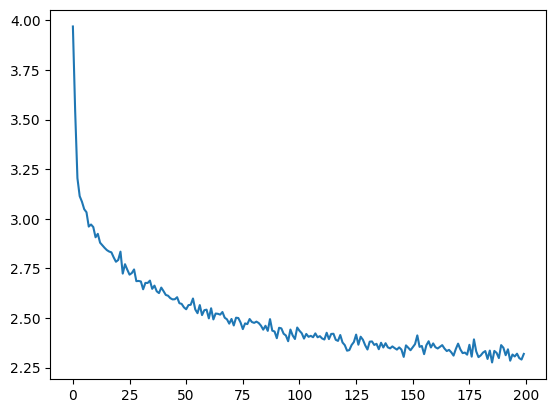

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

### Sampling the Network

In [11]:
max_length: int = 20


def sample(category: str, start_letter: str = 'A') -> str:
    """Sample from a category and starting letter."""
    with torch.no_grad():  # no need to track history in sampling
        category_tensor: torch.Tensor = categoryTensor(category)
        input: torch.Tensor = inputTensor(start_letter)
        hidden: torch.Tensor = rnn.initHidden()
        
        output_name: str = start_letter
        
        for i in range(max_length):
            output: torch.Tensor
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv: torch.Tensor
            topi: torch.Tensor
            topv, topi = output.topk(1)
            topi_item: int = topi[0][0].item()
            if topi_item == n_letters - 1:
                break
            else:
                letter: str = all_letters[topi_item]
                output_name += letter
            input = inputTensor(letter)
        
        return output_name


def samples(category: str, start_letters: str = 'ABC') -> None:
    """Get multiple samples from one category and multiple starting letters."""
    for start_letter in start_letters:
        print(sample(category, start_letter))

# Generate samples
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovaki
Uakin
Shaki
Gertan
Eren
Roure
Sallan
Pare
Aranar
Cun
Han
Iun
